# Coursework 1

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework1.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


def train_model_and_plot_stats0(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True):
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval,
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval,
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')

    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


def train_model_and_plot_stats(
        models, parameters, names, error, learning_rule, train_data, valid_data, num_epochs, stats_interval,
        notebook=True):
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)

    # Use the created objects to initialise a new Optimiser instance.
    optimisers = []
    acc_vals = []
    generalization_gaps = []
    stats = []
    keys = []
    runtimes = []
    for model, parameter in zip(models, parameters):
        optimiser = Optimiser(
            model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)
        optimisers.append(optimiser)

        stat, key, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
        info = []
        for k, v in parameter.items():
            info.append("{} {}".format(k, v))
        info = '&'.join(info)
        # Plot the change in the validation and training set error over training.
        for k in ['error(train)', 'error(valid)']:
            mode = k[6:11]
            if mode == 'train':
                line_style = '-'
            else:
                line_style = '--'
            ax_1.plot(np.arange(1, stat.shape[0]) * stats_interval,
                      stat[1:, key[k]], line_style, label="{}({})".format(info, mode))

        # Plot the change in the validation and training set accuracy over training.

        for k in ['acc(train)', 'acc(valid)']:
            mode = k[4:9]
            if mode == 'train':
                line_style = '-'
            else:
                line_style = '--'
            ax_2.plot(np.arange(1, stat.shape[0]) * stats_interval,
                      stat[1:, key[k]], line_style, label="{}({})".format(info, mode))
        stats.append(stat)
        keys.append(key)
        runtimes.append(run_time)
        acc_vals.append(stat[-1, key['acc(valid)']])
        generalization_gaps.append(stat[-1, key['error(valid)']] - stat[-1, key['error(train)']])

    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    ax_1.set_ylabel('Error')
    fig_1.tight_layout()
    fig_1.savefig(names[0] + '.pdf')
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    ax_2.set_ylabel("Accuracy")
    fig_2.tight_layout()
    fig_2.savefig(names[1] + '.pdf')
    return stats,keys,runtimes,acc_vals, generalization_gaps, fig_1, fig_2, ax_1, ax_2


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


def train_model_and_plot_stats_drop_out(
        models, range, name, error, learning_rule, train_data, valid_data, num_epochs, stats_interval,
        notebook=True):
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    fig = plt.figure(figsize=(8, 4))
    ax_1 = fig.add_subplot(111)
    ax_1.set_xlabel("Dropout value")
    ax_2 = ax_1.twinx()
    ax_1.set_ylabel("Accuracy")
    ax_2.set_ylabel("Generalization gap")
    # Use the created objects to initialise a new Optimiser instance.
    acc_val = []
    generalization_gap = []
    x = range
    for model in models:
        optimiser = Optimiser(
            model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

        stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
        acc_val.append(stats[-1, keys['acc(valid)']])
        generalization_gap.append(stats[-1, keys['error(valid)']] - stats[-1, keys['error(train)']])
    lns1 = ax_1.plot(x, acc_val ,label="Val. Acc.")
    lns2 = ax_2.plot(x, generalization_gap,color='c', label="Gap")
    lns = lns1 + lns2
    labels = [l.get_label() for l in lns]
    ax_1.legend(lns, labels, loc=0)
    fig.savefig(name + '.pdf')
    return acc_val, generalization_gap, fig, ax_1, ax_2

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def train_model_and_plot_stats_penalty(
        models, range, name, error, learning_rule, train_data, valid_data, num_epochs, stats_interval,
        notebook=True):
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    fig = plt.figure(figsize=(8, 4))
    ax_1 = fig.add_subplot(111)
    ax_1.set_xlabel("Dropout value")
    ax_2 = ax_1.twinx()
    ax_1.set_ylabel("Accuracy")
    ax_2.set_ylabel("Generalization gap")
    # Use the created objects to initialise a new Optimiser instance.
    acc_val_l1 = []
    generalization_gap_l1 = []
    x = range
    l1_models = models[0]
    l2_models = models[1]
    for model in l1_models:
        optimiser = Optimiser(
            model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

        stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
        acc_val_l1.append(stats[-1, keys['acc(valid)']])
        generalization_gap_l1.append(stats[-1, keys['error(valid)']] - stats[-1, keys['error(train)']])

    acc_val_l2 = []
    generalization_gap_l2 = []
    for model in l2_models:
        optimiser = Optimiser(
            model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

        stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
        acc_val_l2.append(stats[-1, keys['acc(valid)']])
        generalization_gap_l2.append(stats[-1, keys['error(valid)']] - stats[-1, keys['error(train)']])
    lns1 = ax_1.plot(x, acc_val_l1, '-', label="L1 Val. Acc.")
    lns2 = ax_1.plot(x, acc_val_l2, '-', label="L2 Val. Acc.")
    lns3 = ax_2.plot(x, generalization_gap_l1, '--', label="L1 Gap")
    lns4 = ax_2.plot(x, generalization_gap_l2, '--', label="L2 Gap")

    lns = lns1 + lns2 + lns3 + lns4
    labels = [l.get_label() for l in lns]
    ax_1.legend(lns, labels, loc=0)
    acc_val = [acc_val_l1, acc_val_l2]
    generalization_gap = [generalization_gap_l1, generalization_gap_l2]
    fig.savefig(name + '.pdf')
    return acc_val, generalization_gap, fig, ax_1, ax_2



In [10]:

%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def train_model_and_plot_stats_parameters(
        models, parameters, error, learning_rules, train_data, valid_data, num_epochs, stats_interval,
        notebook=True):
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    fig = plt.figure(figsize=(8, 4))
    ax_1 = fig.add_subplot(111)
    ax_1.set_xlabel("Epoch")
    ax_2 = ax_1.twinx()
    ax_1.set_ylabel("Accuracy")
    ax_2.set_ylabel("Generalization gap")

    fig_2 = plt.figure(figsize=(8, 4))
    ax_3 = fig_2.add_subplot(111)
    ax_3.set_xlabel("Epoch")
    ax_4 = ax_3.twinx()
    ax_3.set_ylabel("Accuracy")
    ax_4.set_ylabel("Generalization gap")
    # Use the created objects to initialise a new Optimiser instance.
    stats = []
    keys = []
    runtimes = []
    lns_fig_1 = None
    lns_fig_2 = None
    generalization_gaps = []
    acc_vals=[]
    L1_n=0
    L2_n=0
    for model, parameter, learning_rule in zip(models, parameters, learning_rules):
        optimiser = Optimiser(
            model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)
        info = []
        for k, v in parameter.items():
            info.append("{} {}".format(k, v))
        info = '&'.join(info)
        stat, key, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
        acc_val = stat[1:, key['acc(valid)']]
        generalization_gap = stat[1:, key['error(valid)']] - stat[1:, key['error(train)']]
        if 'l1' in parameter:
            L1_n+=1
            lns1 = ax_1.plot(np.arange(1, stat.shape[0]) * stats_interval,
                             acc_val, '-', label="{} {}".format("","Val. Acc."))
            lns2 = ax_2.plot(np.arange(1, stat.shape[0]) * stats_interval,
                             generalization_gap, '--', label="{}".format(info))
            if lns_fig_1:
                lns_fig_1 += lns1 + lns2
            else:
                lns_fig_1 = lns1 + lns2
        else:
            lns3 = ax_3.plot(np.arange(1, stat.shape[0]) * stats_interval,
                             acc_val, '', label="{}".format(info))
            lns4 = ax_4.plot(np.arange(1, stat.shape[0]) * stats_interval,
                             generalization_gap, '', label="{}".format(info))
            if lns_fig_2:
                lns_fig_2 += lns3 + lns4
            else:
                lns_fig_2 = lns3 + lns4
        stats.append(stat)
        keys.append(key)
        runtimes.append(run_time)
        acc_vals.append(acc_val)
        generalization_gaps.append(generalization_gap)
    labels_fig_1 = [l.get_label() for l in lns_fig_1]
    ax_1.legend(lns_fig_1, labels_fig_1, loc=0)
    labels_fig_2 = [l.get_label() for l in lns_fig_2]
    ax_3.legend(lns_fig_2, labels_fig_2, loc=0)
    fig.savefig('Combinations with L1.pdf')
    fig_2.savefig('Combinations with L2.pdf')
    return stats, keys, runtimes,acc_vals,generalization_gaps,fig, fig_2, ax_1, ax_2, ax_3, ax_4




In [2]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider

# Seed a random number generator
seed = 11102019
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
train_data.reset()
valid_data.reset()

KeysView(<numpy.lib.npyio.NpzFile object at 0x0000023F8460A820>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x0000023F8460A4C0>)


In [16]:
# The model set up code below is provided as a starting point.
# You will probably want to IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.htmladd further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser

#setup hyperparameters
learning_rate = 0.1
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule()

#Remember to use notebook=False when you write a script to be run in a terminal
_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

NameError: name 'train_model_and_plot_stats' is not defined

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[0.7853797468354433, 0.8105696202531639, 0.8080379746835443]
[0.14839860177771824, 0.3392892050750146, 0.7815757828542148]


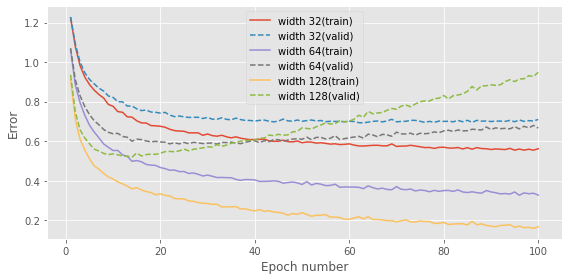

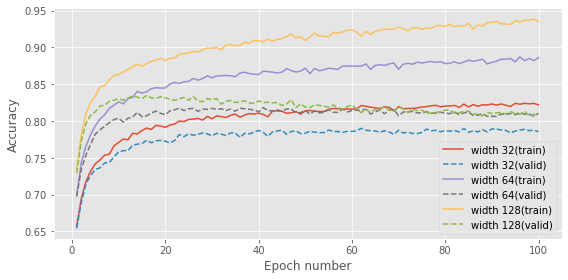

In [12]:
# Table 1 & Figure 2
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser

seed = 11102019
rng = np.random.RandomState(seed)
train_data.reset()
valid_data.reset()
#setup hyperparameters
learning_rate = 1e-3
num_epochs = 100
stats_interval = 1
input_dim, output_dim = 784, 47
paramerters = [
    {'width': 32},
    {'width': 64},
    {'width': 128},
]
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
hidden_dims = [32, 64, 128]
models = []

for hidden_dim in hidden_dims:
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        # AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        # ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])
    models.append(model)
learning_rule = AdamLearningRule(learning_rate=learning_rate)

error = CrossEntropySoftmaxError()
names = ['error_curve_width', 'acc_curve_width']
#Remember to use notebook=False when you write a script to be run in a terminal
stats,keys,runtimes, acc_vals, generalization_gaps, fig_1, fig_2, ax_1, ax_2 = train_model_and_plot_stats(
    models, paramerters, names, error, learning_rule, train_data, valid_data, num_epochs, stats_interval,
    notebook=True)
print(acc_vals)
print(generalization_gaps)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[0.8049367088607597, 0.8151265822784808, 0.8210126582278481]
[0.798221749020721, 1.4293521084755776, 1.5645498033822975]


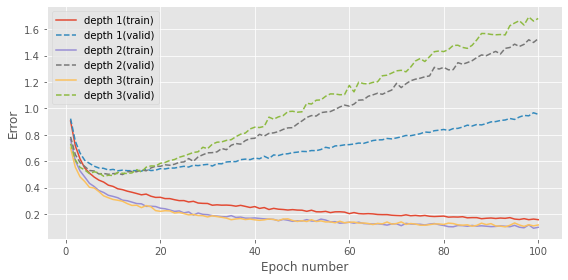

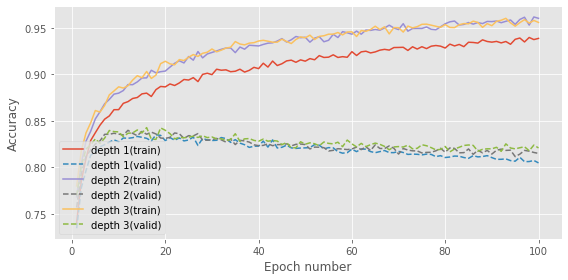

In [13]:
# Table 2 & Figure 3
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser
seed = 11102019
rng = np.random.RandomState(seed)
train_data.reset()
valid_data.reset()
#setup hyperparameters
learning_rate = 1e-3
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128
paramerters = [
    {'depth': 1},
    {'depth': 2},
    {'depth': 3},
]
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
hidden_layers = [1, 2, 3]
models = []
learning_rules = []
for hidden_layer in hidden_layers:
    # input layer
    layers = [
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        ReluLayer()
    ]
    # hidden layer
    hidden_layer-=1
    for _ in range(hidden_layer):
        layers.append(AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init))
        layers.append(ReluLayer())
    # output layer
    layers.append(AffineLayer(hidden_dim, output_dim, weights_init, biases_init))
    model = MultipleLayerModel(layers)
    models.append(model)
learning_rule = AdamLearningRule(learning_rate=learning_rate)

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule

names = ['error_curve_depth', 'acc_curve_depth']
#Remember to use notebook=False when you write a script to be run in a terminal
stats,keys,runtimes,acc_val, generalization_gap, fig_1, fig_2, ax_1, ax_2 = train_model_and_plot_stats(
    models, paramerters, names, error, learning_rule, train_data, valid_data, num_epochs, stats_interval,
    notebook=True)
print(acc_val)
print(generalization_gap)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[0.1071518987341771, 0.6848101265822785, 0.797025316455696, 0.8395569620253159, 0.8493037974683543]
[0.005868093221384818, 0.044453823590595354, 0.07324445846266381, 0.1176255610818131, 0.2762284231901194]


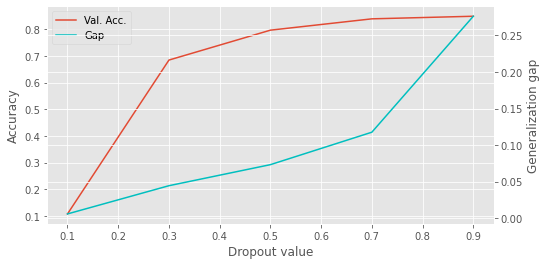

In [14]:
# drop out

# The model set up code below is provided as a starting point.
# You will probably want to IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.htmladd further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, DropoutLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser

seed = 11102019
rng = np.random.RandomState(seed)
train_data.reset()
valid_data.reset()
#setup hyperparameters

learning_rate = 1e-3
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128
drop_outs = [0.1, 0.3, 0.5, 0.7, 0.9]
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
models = []

for drop_out in drop_outs:
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        DropoutLayer(rng=rng, incl_prob=drop_out),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        DropoutLayer(rng=rng, incl_prob=drop_out),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        DropoutLayer(rng=rng, incl_prob=drop_out),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])
    models.append(model)

learning_rule = AdamLearningRule(learning_rate=learning_rate)
error = CrossEntropySoftmaxError()

#Remember to use notebook=False when you write a script to be run in a terminal
name = 'metrics_by_dropout_rate'
#Remember to use notebook=False when you write a script to be run in a terminal
acc_vals, generalization_gaps, fig, ax_1, ax_2 = train_model_and_plot_stats_drop_out(
    models, drop_outs, name, error, learning_rule, train_data, valid_data, num_epochs, stats_interval,
    notebook=True)

print(acc_vals)
print(generalization_gaps)

Text(0, 0.5, 'Generalization gap')

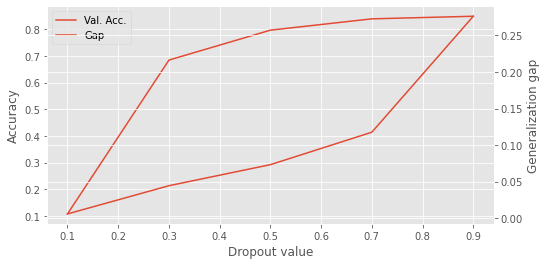

In [15]:
fig = plt.figure(figsize=(8, 4))
ax_1 = fig.add_subplot(111)
ax_2 = ax_1.twinx()
lns1 = ax_1.plot(drop_outs, acc_vals, label="Val. Acc.")
lns2 = ax_2.plot(drop_outs, generalization_gaps, label="Gap")
lns = lns1 + lns2
labels = [l.get_label() for l in lns]
ax_1.legend(lns, labels, loc=0)
ax_1.set_xlabel("Dropout value")
ax_1.set_ylabel("Accuracy")
ax_2.set_ylabel("Generalization gap")


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

[[0.835759493670886, 0.8513291139240508, 0.7637341772151895, 0.02012658227848099, 0.019810126582278462], [0.8198101265822778, 0.8346835443037972, 0.8527215189873417, 0.7549367088607596, 0.020443037974683515]]
[[0.7828932080090236, 0.0960163115447839, 0.01918288591086903, 0.0005990478524293685, 0.00039883591168043964], [1.2725430185483633, 0.5170387116092038, 0.06464799317022579, 0.007889072828258015, 0.0005240657691412132]]


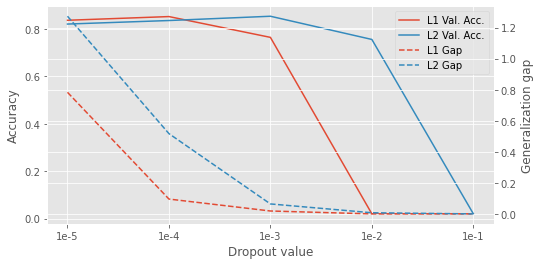

In [17]:
# L1 L2

# The model set up code below is provided as a starting point.
# You will probably want to IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.htmladd further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, DropoutLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser
from mlp.penalties import L1Penalty, L2Penalty
seed = 11102019
rng = np.random.RandomState(seed)
train_data.reset()
valid_data.reset()
#setup hyperparameters
learning_rate = 1e-3
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128
penalties = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
models = []
L1_models = []
L2_models = []
for l in penalties:
    l1_penalty = L1Penalty(coefficient=l)
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty=l1_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=l1_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=l1_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty=l1_penalty)
    ])
    L1_models.append(model)
    l2_penalty = L2Penalty(coefficient=l)
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty=l2_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=l2_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=l2_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty=l2_penalty)
    ])
    L2_models.append(model)
models.append(L1_models)
models.append(L2_models)

learning_rule = AdamLearningRule(learning_rate=learning_rate)

error = CrossEntropySoftmaxError()

#Remember to use notebook=False when you write a script to be run in a terminal
name = 'metrics_by_weight_penalty'
penalties_str = ['1e-5', '1e-4', '1e-3', '1e-2', '1e-1']
#Remember to use notebook=False when you write a script to be run in a terminal
acc_val, generalization_gap, fig, ax_1, ax_2 = train_model_and_plot_stats_penalty(
    models, penalties_str, name, error, learning_rule, train_data, valid_data, num_epochs, stats_interval,
    notebook=True)

print(acc_val)
print(generalization_gap)



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

NameError: name 'acc_val' is not defined

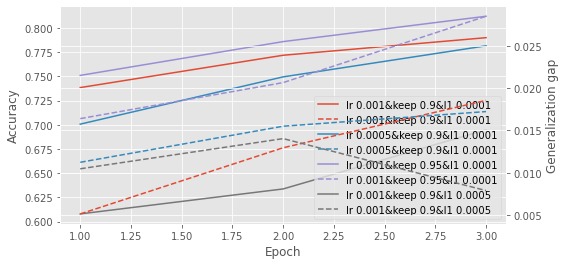

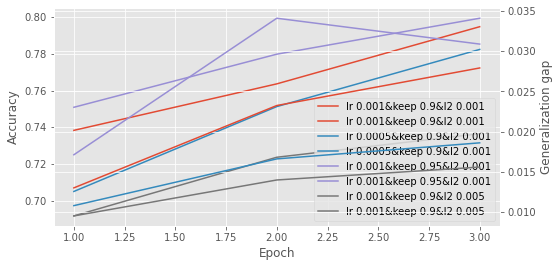

In [15]:
# combine


# The model set up code below is provided as a starting point.
# You will probably want to IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.htmladd further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, DropoutLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser
from mlp.penalties import L2Penalty,L1Penalty
train_data.reset()
valid_data.reset()
#setup hyperparameters
num_epochs = 3
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
models = []
paramerters = [
    {'lr': 1e-3, 'keep': 0.9, 'l1': 1e-4},
    {'lr': 1e-3, 'keep': 0.9, 'l2': 1e-3},
    {'lr': 5e-4, 'keep': 0.9, 'l1': 1e-4},
    {'lr': 5e-4, 'keep': 0.9, 'l2': 1e-3},
    {'lr': 1e-3, 'keep': 0.95, 'l1': 1e-4},
    {'lr': 1e-3, 'keep': 0.95, 'l2': 1e-3},
    {'lr': 1e-3, 'keep': 0.9, 'l1': 5e-4},
    {'lr': 1e-3, 'keep': 0.9, 'l2': 5e-3},
]
seeds = [1000, 21000, 41000, 61000]
learning_rules = []
for paramerter in paramerters:
    if 'l1' in paramerter:
        penalty = L1Penalty(coefficient=paramerter['l1'])
    else:
        penalty = L2Penalty(coefficient=paramerter['l2'])
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty=penalty),
        ReluLayer(),
        DropoutLayer(rng=np.random.RandomState(seeds[0]), incl_prob=paramerter['keep']),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=penalty),
        ReluLayer(),
        DropoutLayer(rng=np.random.RandomState(seeds[1]), incl_prob=paramerter['keep']),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=penalty),
        ReluLayer(),
        DropoutLayer(rng=np.random.RandomState(seeds[2]), incl_prob=paramerter['keep']),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty=penalty)
    ])
    learning_rules.append(AdamLearningRule(learning_rate=paramerter['lr']))
    models.append(model)

error = CrossEntropySoftmaxError()

#Remember to use notebook=False when you write a script to be run in a terminal
stats, keys, runtimes,acc_vals,generalization_gaps,fig, fig_2, ax_1, ax_2, ax_3, ax_4 = train_model_and_plot_stats_parameters(
    models, paramerters, error, learning_rules, train_data, valid_data, num_epochs, stats_interval,
    notebook=True)
print(acc_vals)
print(generalization_gaps)

